In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [2]:
path1 = './dataset/historical_data.csv'
path2 = './dataset/poptable.csv'

In [3]:
state = pd.read_csv(path2)

In [4]:
df=pd.read_csv('./dataset/historical_data.csv', encoding="ISO-8859-1", parse_dates=['date'])
df.head()

/tmp/ipykernel_3213/1707999065.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./dataset/historical_data.csv', encoding="ISO-8859-1", parse_dates=['date'])


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   stn_code                     291665 non-null  object        
 1   sampling_date                435739 non-null  object        
 2   state                        435742 non-null  object        
 3   location                     435739 non-null  object        
 4   agency                       286261 non-null  object        
 5   type                         430349 non-null  object        
 6   so2                          401096 non-null  float64       
 7   no2                          419509 non-null  float64       
 8   rspm                         395520 non-null  float64       
 9   spm                          198355 non-null  float64       
 10  location_monitoring_station  408251 non-null  object        
 11  pm2_5                     

In [6]:
drop_cols = ['stn_code', 'sampling_date', 'location', 'agency', 'type', 
             'location_monitoring_station']
df.drop(drop_cols, inplace=True, axis=1)

In [7]:
df.head()

,state,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [8]:
df=pd.merge(state.set_index("state"),df.set_index("state"), right_index=True, left_index=True).reset_index()
df.head()

,state,latitude,longitude,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,14.750429,78.570026,4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,14.750429,78.570026,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,14.750429,78.570026,6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,14.750429,78.570026,6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,14.750429,78.570026,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [9]:
df.isna().sum()

state             0
latitude          0
longitude         0
so2           30451
no2           15014
rspm          36451
spm          214211
pm2_5        382855
date              5
dtype: int64

## Cleaning Data

### Filling missing value

In [10]:
col_na = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
for col in col_na:
    df[col].fillna(df[col].median(), inplace=True)

In [11]:
df.isna().sum()

state        0
latitude     0
longitude    0
so2          0
no2          0
rspm         0
spm          0
pm2_5        0
date         5
dtype: int64

In [12]:
df.dropna(inplace=True)

## date-fix

In [13]:
df['year']= df['date'].apply(lambda x: x.year)
df['month']= df['date'].apply(lambda x: x.month)
df['day']= df['date'].apply(lambda x: x.day)

## Calculate AQI

In [14]:
import pandas as pd

def calculate_aqi(parameter, concentration):
    # Define specific AQI breakpoints and corresponding AQI values for each parameter based on Indian standards
    parameter_breakpoints = {
        'so2': [0, 40, 80, 380, 800, 1600],
        'no2': [0, 40, 80, 180, 280, 400],
        'rspm': [0, 30, 60, 90, 180, 280],
        'spm': [0, 50, 100, 200, 300, 400],
        'pm2_5': [0, 30, 60, 90, 120, 250]
    }

    aqi_values = [0, 50, 100, 200, 300, 400, 500]

    for i in range(len(parameter_breakpoints[parameter]) - 1):
        if parameter_breakpoints[parameter][i] <= concentration <= parameter_breakpoints[parameter][i + 1]:
            break

    return ((aqi_values[i + 1] - aqi_values[i]) / (parameter_breakpoints[parameter][i + 1] - parameter_breakpoints[parameter][i])) * (concentration - parameter_breakpoints[parameter][i]) + aqi_values[i]

def calculate_overall_aqi(row):
    parameters = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
    aqi_values = [calculate_aqi(parameter, row[parameter]) for parameter in parameters]
    return max(aqi_values)

def interpret_aqi(aqi):
    if 0 <= aqi <= 50:
        return "Good"
    elif 51 <= aqi <= 100:
        return "Satisfactory"
    elif 101 <= aqi <= 200:
        return "Moderate"
    elif 201 <= aqi <= 300:
        return "Poor"
    elif 301 <= aqi <= 400:
        return "Very Poor"
    elif 401 <= aqi <= 500:
        return "Severe"
    else:
        return "Invalid AQI value"

def calculate_aqi_for_dataframe(df):
    df['aqi'] = df.apply(calculate_overall_aqi, axis=1)
    df['aqi_cat'] = df['aqi'].apply(interpret_aqi)
    return df

In [15]:
df = calculate_aqi_for_dataframe(df)

In [16]:
df.head(1)

,state,latitude,longitude,so2,no2,rspm,spm,pm2_5,date,year,month,day,aqi,aqi_cat
0,Andhra Pradesh,14.750429,78.570026,4.8,17.4,90.0,192.0,31.0,1990-02-01,1990,2,1,200.0,Moderate


In [17]:
df[['year','aqi']].groupby('year').mean().describe()

,aqi
count,29.000000
mean,257.053048
std,21.951486
min,215.030044
25%,242.810407
50%,253.775140
75%,273.155924
max,318.791525


<Axes: xlabel='year'>

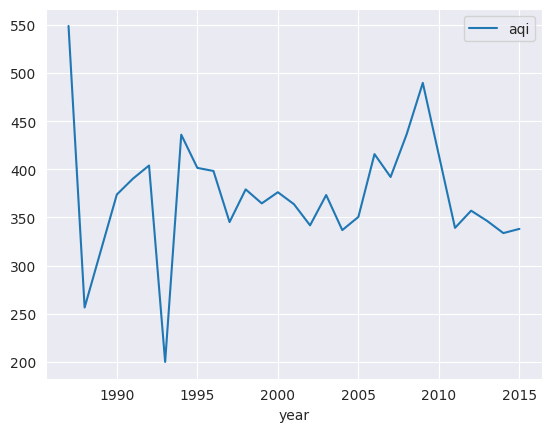

In [18]:
df[ df.state =='Delhi'][['aqi','year']].groupby('year').mean().plot()

### cat-codes

In [19]:
df.state.unique()

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Delhi', 'Goa', 'Haryana',
       'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Uttar Pradesh', 'Uttaranchal', 'West Bengal'],
      dtype=object)

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()
le.fit(df.state)
df['state'] = le.transform(df.state)

In [22]:
df.state.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

## Model Training

In [23]:
indep = ['state','year', 'month','aqi']
dep = 'aqi'

In [24]:
x = df[indep].groupby(['state','year','month']).mean().reset_index()
y = x['aqi']
x = x[['state','year','month']]

In [25]:
x.sort_values(by=['year','month'], inplace=True)

#### Train test split

In [26]:
x_train, x_test = x[x.year>=1800][x.year<2015],x[x.year==2015]
y_train, y_test = y[x_train.index], y[x_test.index]

In [27]:
x_train.shape, x_test.shape

((6056, 3), (259, 3))

### Model1

In [28]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(300,max_depth=10)
m.fit(x_train, y_train)
pred = m.predict(x_test)
m.score(x_test, y_test)

0.7627832794894525

In [29]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

457.4525137337072

### Model2


In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
pred = tree.predict(x_test)
tree.score(x_test, y_test)

0.7910488459476583

### Model3

In [32]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)
pred = svr.predict(x_test)
svr.score(x_test, y_test)

-0.03364246680817162

# max 79.1% r2 score

In [33]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

def print_score(x_test=x_test, y_test=y_test):
    y_true = y_test
    y_pred = weighted_avg(models, weights, x_test)['prediction']
    
    print('f1 mean_squared_error: ', mean_squared_error(y_true, y_pred))
    print('r2_score : ', r2_score(y_true, y_pred))
    # print('accuracy_score : ', accuracy_score(y_true, y_pred))

## Weighted Avg

In [34]:
def weighted_avg(models: list, weights: list, predict_df: pd.DataFrame):
    """
    calculates weighted average of predictions of list of models
    """
    preds = pd.DataFrame()
    
    for i, m in enumerate(models):
        m.fit(x_train, y_train)
        preds[i] = m.predict(predict_df)
        
    preds['weighted_pred'] = (preds * weights).sum(axis=1) / sum(weights)
    preds['prediction'] = preds['weighted_pred']
    return preds

In [38]:
models = [
    RandomForestRegressor(100,max_depth=10, random_state=42),
    DecisionTreeRegressor(random_state=42),
    SVR()
]

# set weights 
weights = [0.5,0.7,0.1]

# calculating final predictions
preds = weighted_avg(models, weights, x_test)

print_score()   # score on training data

f1 mean_squared_error:  383.1532392770951
r2_score :  0.801311934800702


So the error improved and now we can use this model for future use

# 80.1% r2 score

In [39]:
def train_models(models, weights):
    trained_models = []
    for i,m in enumerate(models):
        m.fit(x_train, y_train)
        trained_models.append(m)
    return trained_models

# saving models

In [40]:
models = [
    RandomForestRegressor(100,max_depth=10, random_state=42),
    DecisionTreeRegressor(random_state=42),
    SVR()
]

# set weights 
weights = [0.5,0.7,0.1]

# train models
trained_models = train_models(models, weights)

In [41]:
import joblib

In [42]:
joblib.dump(models, "weighted_models.pkl")
joblib.dump(weights, "model_weights.pkl")

['model_weights.pkl']

## Load Models

In [40]:
import joblib

# Load the models and weights
models = joblib.load("weighted_models.pkl")
weights = joblib.load("model_weights.pkl")

# Define a function for weighted averaging
def weighted_average_prediction(models, weights, input_data):
    predictions = [model.predict(input_data) for model in models]
    weighted_prediction = sum(weight * prediction for weight, prediction in zip(weights, predictions))
    return weighted_prediction

def weighted_avg(models: list, weights: list, predict_df: pd.DataFrame):
    """
    calculates weighted average of predictions of list of models
    """
    preds = pd.DataFrame()
    
    for i, m in enumerate(models):
        m.fit(x_train, y_train)
        preds[i] = m.predict(predict_df)
        
    preds['weighted_pred'] = (preds * weights).sum(axis=1) / sum(weights)
    preds['prediction'] = preds['weighted_pred']
    return preds



In [45]:
mapping = dict(zip(range(len(le.classes_)), le.classes_))

In [48]:
from constants import state_dict_reverse

In [60]:
x['aqi'] = y

In [62]:
x.to_csv('historical_data_cleaned.csv', index=None)